In [1]:
# Temporary imports cell to ensure kernel has required modules loaded
import sys
print('Python', sys.version)
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from sklearn.inspection import permutation_importance
import joblib
import warnings
warnings.filterwarnings('ignore')
print('Imports done')


Python 3.11.6 (tags/v3.11.6:8b6ee5b, Oct  2 2023, 14:57:12) [MSC v.1935 64 bit (AMD64)]


Imports done


# Decision Tree and Random Forest training notebook

This notebook builds, evaluates, visualizes, tunes, and saves Decision Tree and Random Forest models for the
`cybersecurity_intrusion_data.csv` dataset. It follows the project's preprocessing conventions (numeric scaling + one-hot
encoding for categoricals) and saves models to the repository `models/` folder.


In [2]:
# Section 1: Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from sklearn.inspection import permutation_importance
import joblib
import warnings
warnings.filterwarnings('ignore')

RANDOM_STATE = 42
sns.set(style='whitegrid')


In [3]:
# Section 2: Load dataset
# Notebook-friendly path (workspace relative). Adjust if you open the notebook from a different working directory.
DATA_PATH = Path('../../Sheets/cybersecurity_intrusion_data.csv').resolve()
print('Loading data from:', DATA_PATH)
df = pd.read_csv(DATA_PATH)
print('Data shape:', df.shape)
df.head()


Loading data from: C:\Users\ACER\Downloads\-Cybersecurity-Suspicious-Web-Threat-Interactions\Sheets\cybersecurity_intrusion_data.csv
Data shape: (9537, 11)


,session_id,network_packet_size,protocol_type,login_attempts,session_duration,encryption_used,ip_reputation_score,failed_logins,browser_type,unusual_time_access,attack_detected
0,SID_00001,599,TCP,4,492.983263,DES,0.606818,1,Edge,0,1
1,SID_00002,472,TCP,3,1557.996461,DES,0.301569,0,Firefox,0,0
2,SID_00003,629,TCP,3,75.044262,DES,0.739164,2,Chrome,0,1
3,SID_00004,804,UDP,4,601.248835,DES,0.123267,0,Unknown,0,1
4,SID_00005,453,TCP,5,532.540888,AES,0.054874,1,Firefox,0,0


In [4]:
# Section 3: Exploratory data check & preprocessing notes
print('\n--- Basic info ---')
print(df.info())

print('\n--- Description (numeric) ---')
print(df.describe().T)

print('\n--- Class distribution ---')
print(df['attack_detected'].value_counts())
print(df['attack_detected'].value_counts(normalize=True))

# Basic missing value check
print('\n--- Missing values per column ---')
print(df.isnull().sum())

# Define feature groups
numeric_features = [
    'network_packet_size',
    'login_attempts',
    'session_duration',
    'ip_reputation_score',
    'failed_logins',
    'unusual_time_access'
]
categorical_features = ['protocol_type', 'encryption_used', 'browser_type']

# Keep only available columns (defensive)
available = set(df.columns)
numeric_features = [c for c in numeric_features if c in available]
categorical_features = [c for c in categorical_features if c in available]

print('\nNumeric features:', numeric_features)
print('Categorical features:', categorical_features)



--- Basic info ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9537 entries, 0 to 9536
Data columns (total 11 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   session_id           9537 non-null   object 
 1   network_packet_size  9537 non-null   int64  
 2   protocol_type        9537 non-null   object 
 3   login_attempts       9537 non-null   int64  
 4   session_duration     9537 non-null   float64
 5   encryption_used      7571 non-null   object 
 6   ip_reputation_score  9537 non-null   float64
 7   failed_logins        9537 non-null   int64  
 8   browser_type         9537 non-null   object 
 9   unusual_time_access  9537 non-null   int64  
 10  attack_detected      9537 non-null   int64  
dtypes: float64(2), int64(5), object(4)
memory usage: 819.7+ KB
None

--- Description (numeric) ---
                      count        mean         std        min         25%  \
network_packet_size  9537.0  500.430639  198.

In [5]:
# Section 4: Preprocessing pipeline
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

# Build preprocessor similar to scripts/train_models.py
numeric_transformer = Pipeline(steps=[('scaler', StandardScaler())])
categorical_transformer = Pipeline(steps=[('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features),
    ],
    remainder='drop'
)

# Fit the preprocessor to allow extraction of feature names later
preprocessor.fit(df[numeric_features + categorical_features])

# Derive feature names after preprocessing (for feature importance plots)
feature_names = []
if numeric_features:
    feature_names.extend(numeric_features)
if categorical_features:
    ohe = preprocessor.named_transformers_['cat'].named_steps['onehot']
    cat_names = list(ohe.get_feature_names_out(categorical_features))
    feature_names.extend(cat_names)

print('\nPreprocessed feature count:', len(feature_names))



Preprocessed feature count: 17


In [6]:
# Section 5: Train / test split
TARGET = 'attack_detected'
X = df[numeric_features + categorical_features]
y = df[TARGET].astype(int)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y
)

print('Train shape:', X_train.shape)
print('Test shape:', X_test.shape)
print('\nTrain class balance:')
print(y_train.value_counts(normalize=True))


Train shape: (7629, 9)
Test shape: (1908, 9)

Train class balance:
attack_detected
0    0.55289
1    0.44711
Name: proportion, dtype: float64


In [7]:
# Section 6: Decision Tree — train and evaluate
# Build pipeline combining the preprocessor and the tree classifier
from sklearn.tree import DecisionTreeClassifier

dt_pipeline = Pipeline(steps=[('preproc', preprocessor), ('clf', DecisionTreeClassifier(random_state=RANDOM_STATE))])

# Fit
dt_pipeline.fit(X_train, y_train)

# Predict & evaluate
y_pred = dt_pipeline.predict(X_test)
print('\nDecision Tree — Test set results')
print(classification_report(y_test, y_pred, digits=4))
print('Confusion matrix:')
print(confusion_matrix(y_test, y_pred))

# Cross-validated ROC AUC (pipeline will apply preprocessing inside CV)
cv_scores = cross_val_score(dt_pipeline, X, y, cv=5, scoring='roc_auc', n_jobs=-1)
print('\nCross-validated ROC AUC (5-fold):')
print(cv_scores)
print('Mean ROC AUC:', np.mean(cv_scores))



Decision Tree — Test set results
              precision    recall  f1-score   support

           0     0.8366    0.8540    0.8452      1055
           1     0.8147    0.7937    0.8040       853

    accuracy                         0.8270      1908
   macro avg     0.8256    0.8238    0.8246      1908
weighted avg     0.8268    0.8270    0.8268      1908

Confusion matrix:
[[901 154]
 [176 677]]



Cross-validated ROC AUC (5-fold):
[0.8038437  0.80800965 0.81368137 0.81022165 0.81880882]
Mean ROC AUC: 0.8109130379177583


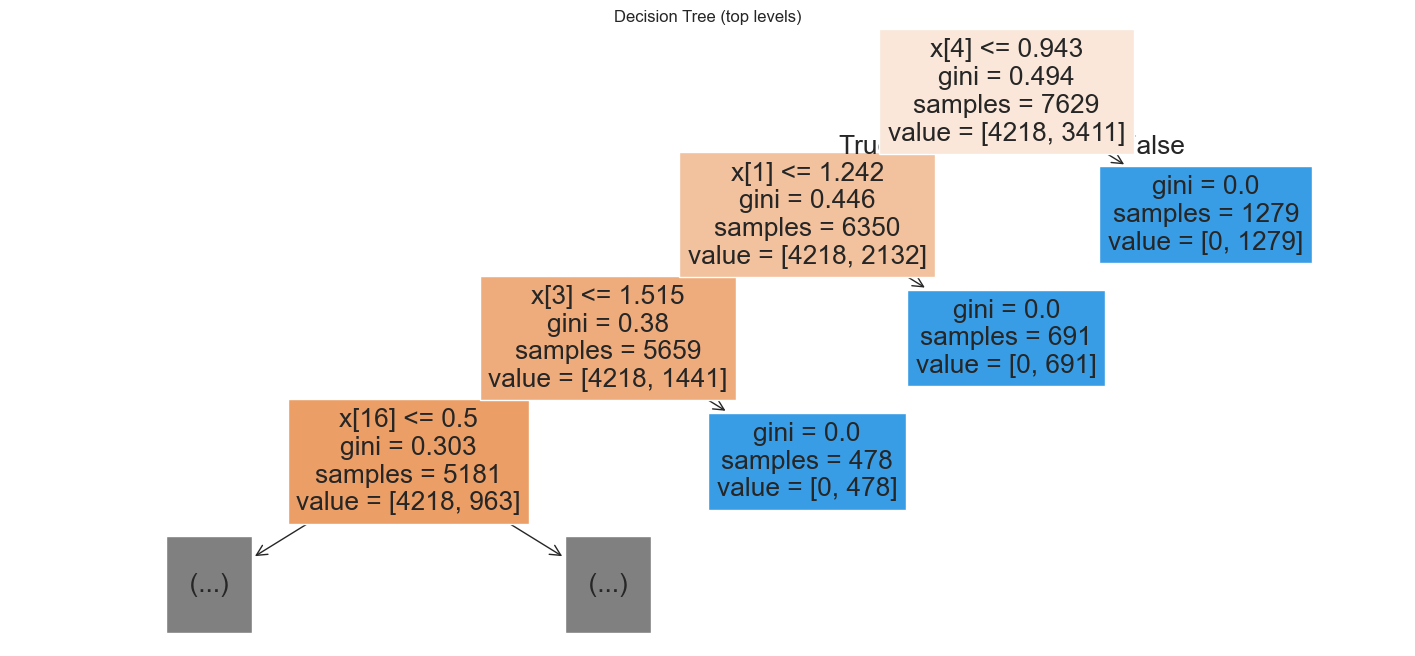

In [8]:
# Section 7: Decision Tree — visualize tree (shallow depth for readability)
import matplotlib.pyplot as plt
clf = dt_pipeline.named_steps['clf']

# Transform a small sample to get the correct shape
X_test_trans = dt_pipeline.named_steps['preproc'].transform(X_test)

plt.figure(figsize=(18,8))
plot_tree(clf, max_depth=3, filled=True)
plt.title('Decision Tree (top levels)')
plt.show()


In [9]:
# Section 8: Decision Tree — feature importance & pruning
# Feature importances (note: these correspond to the preprocessed feature ordering)
import pandas as pd
import numpy as np

imp = clf.feature_importances_
if len(imp) == len(feature_names):
    fi = pd.Series(imp, index=feature_names).sort_values(ascending=False)
else:
    fi = pd.Series(imp).sort_values(ascending=False)

print('\nTop features (Decision Tree):')
print(fi.head(15))

# Cost-complexity pruning path
X_train_trans = dt_pipeline.named_steps['preproc'].transform(X_train)
path = clf.cost_complexity_pruning_path(X_train_trans, y_train)
ccp_alphas, impurities = path.ccp_alphas, path.impurities

# Train trees using the different alphas
clfs = []
for ccp_alpha in ccp_alphas[:10]:  # limit for speed
    clf_tmp = DecisionTreeClassifier(random_state=RANDOM_STATE, ccp_alpha=ccp_alpha)
    clf_tmp.fit(X_train_trans, y_train)
    clfs.append((ccp_alpha, clf_tmp))

print('\nTrained {} pruned trees (sample of alphas)'.format(len(clfs)))



Top features (Decision Tree):
failed_logins           0.265197
login_attempts          0.240665
ip_reputation_score     0.237247
session_duration        0.093366
network_packet_size     0.078083
browser_type_Unknown    0.027384
unusual_time_access     0.012826
browser_type_Chrome     0.006820
browser_type_Edge       0.006139
protocol_type_UDP       0.005905
protocol_type_TCP       0.005797
encryption_used_nan     0.004155
protocol_type_ICMP      0.003978
browser_type_Firefox    0.003889
encryption_used_DES     0.003847
dtype: float64



Trained 10 pruned trees (sample of alphas)


In [10]:
# Section 9: Random Forest — train and evaluate
rf_pipeline = Pipeline(steps=[('preproc', preprocessor), ('clf', RandomForestClassifier(n_estimators=100, random_state=RANDOM_STATE, oob_score=True, n_jobs=-1))])
rf_pipeline.fit(X_train, y_train)

# Predict & evaluate
y_pred_rf = rf_pipeline.predict(X_test)
print('\nRandom Forest — Test set results')
print(classification_report(y_test, y_pred_rf, digits=4))
print('Confusion matrix:')
print(confusion_matrix(y_test, y_pred_rf))

# OOB score
rf_clf = rf_pipeline.named_steps['clf']
if hasattr(rf_clf, 'oob_score_'):
    print('\nRandom Forest OOB score:', rf_clf.oob_score_)

# Feature importances
imp_rf = rf_clf.feature_importances_
if len(imp_rf) == len(feature_names):
    fi_rf = pd.Series(imp_rf, index=feature_names).sort_values(ascending=False)
else:
    fi_rf = pd.Series(imp_rf).sort_values(ascending=False)

print('\nTop features (Random Forest):')
print(fi_rf.head(15))

# Permutation importance (optional, can be slower)
perm = permutation_importance(rf_pipeline, X_test, y_test, n_repeats=10, random_state=RANDOM_STATE, n_jobs=-1)
perm_idx = perm.importances_mean.argsort()[::-1]
print('\nTop permutation importances:')
for i in perm_idx[:10]:
    name = feature_names[i] if i < len(feature_names) else f'X{i}'
    print(f"{name}: {perm.importances_mean[i]:.4f} (+/- {perm.importances_std[i]:.4f})")



Random Forest — Test set results
              precision    recall  f1-score   support

           0     0.8296    0.9924    0.9038      1055
           1     0.9876    0.7479    0.8512       853

    accuracy                         0.8831      1908
   macro avg     0.9086    0.8702    0.8775      1908
weighted avg     0.9003    0.8831    0.8803      1908

Confusion matrix:
[[1047    8]
 [ 215  638]]

Random Forest OOB score: 0.8927775593131472

Top features (Random Forest):
failed_logins           0.283249
ip_reputation_score     0.223466
login_attempts          0.223350
session_duration        0.100382
network_packet_size     0.091179
browser_type_Unknown    0.024166
unusual_time_access     0.008813
protocol_type_TCP       0.005516
browser_type_Chrome     0.005248
protocol_type_UDP       0.005028
browser_type_Edge       0.004841
encryption_used_AES     0.004765
browser_type_Firefox    0.004654
encryption_used_DES     0.004641
encryption_used_nan     0.004616
dtype: float64



Top permutation importances:
failed_logins: 0.1792 (+/- 0.0078)
login_attempts: 0.1240 (+/- 0.0062)
ip_reputation_score: 0.0948 (+/- 0.0052)
protocol_type_UDP: 0.0286 (+/- 0.0029)
session_duration: 0.0039 (+/- 0.0023)
unusual_time_access: 0.0032 (+/- 0.0008)
protocol_type_ICMP: -0.0008 (+/- 0.0007)
network_packet_size: -0.0010 (+/- 0.0011)
protocol_type_TCP: -0.0012 (+/- 0.0008)


In [11]:
# Section 10: Hyperparameter tuning (GridSearchCV example for Random Forest)
param_grid = {
    'clf__n_estimators': [50, 100],
    'clf__max_depth': [None, 10, 20],
    'clf__max_features': ['sqrt', 'log2']
}

grid = GridSearchCV(rf_pipeline, param_grid, cv=3, scoring='roc_auc', n_jobs=-1, verbose=1)
grid.fit(X_train, y_train)
print('\nBest params (GridSearch):', grid.best_params_)
print('Best CV ROC AUC:', grid.best_score_)

best_rf = grid.best_estimator_
# Evaluate on test set
y_pred_grid = best_rf.predict(X_test)
print('\nGrid Seached RF — Test set')
print(classification_report(y_test, y_pred_grid, digits=4))
print('Confusion matrix:')
print(confusion_matrix(y_test, y_pred_grid))


Fitting 3 folds for each of 12 candidates, totalling 36 fits



Best params (GridSearch): {'clf__max_depth': 20, 'clf__max_features': 'sqrt', 'clf__n_estimators': 50}
Best CV ROC AUC: 0.8892131264718405

Grid Seached RF — Test set
              precision    recall  f1-score   support

           0     0.8302    0.9962    0.9056      1055
           1     0.9938    0.7479    0.8535       853

    accuracy                         0.8852      1908
   macro avg     0.9120    0.8721    0.8796      1908
weighted avg     0.9033    0.8852    0.8823      1908

Confusion matrix:
[[1051    4]
 [ 215  638]]


In [12]:
# Section 11: Save models and notebook export notes
MODEL_DIR = Path('../../models').resolve()
MODEL_DIR.mkdir(parents=True, exist_ok=True)

joblib.dump(dt_pipeline, MODEL_DIR / 'decision_tree_model.joblib')
joblib.dump(rf_pipeline, MODEL_DIR / 'random_forest_model.joblib')
# Save the best grid-searched model if available
try:
    joblib.dump(best_rf, MODEL_DIR / 'random_forest_best_grid.joblib')
except NameError:
    pass

print('Models saved to:', MODEL_DIR)

# Notebook export note (run in integrated terminal if you want a clean exported copy):
# jupyter nbconvert --to notebook --output exported_train_tree_models.ipynb train_tree_models.ipynb


Models saved to: C:\Users\ACER\Downloads\-Cybersecurity-Suspicious-Web-Threat-Interactions\Models
